In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import scipy.stats as sts

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens

import tensorflow as tf
from tensorflow import keras

# from keras import models as kermdls
# from keras import layers as kerlrs
# from keras import metrics as kmetrics

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe

import pickle

import nilearn as nl
from nilearn import plotting, image
from nilearn import datasets
import nibabel as nb
import h5py

import os

import time

Using TensorFlow backend.


In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8191679041174024553
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13955303650902987164
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6589725830
locality {
  bus_id: 1
  links {
  }
}
incarnation: 463912262684540053
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2849334017170988258
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
TEST_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_test'))]
TRAIN_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_train'))]

In [6]:
data = pd.read_csv('00_Data/train_scores.csv')
data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235


In [7]:
data.isnull().sum()

Id                0
age               0
domain1_var1    438
domain1_var2    438
domain2_var1     39
domain2_var2     39
dtype: int64

In [8]:
data = data.dropna()

In [9]:
print('Dataset length: ', len(data.index))

Dataset length:  5434


In [10]:
def get_inputs(idx, labels):
    # FNC inputs
    df_fnc = pd.read_csv('00_Data/fnc_csv/{0}.csv'.format(idx), index_col=0)
    X_fnc = np.array(df_fnc.values).reshape(-1)
    
    # Loading inputs
    df_loading = pd.read_csv('00_Data/loading_csv/{0}.csv'.format(idx), index_col=0)
    X_loading = np.array(df_loading.values).reshape(-1)
    
    #MRI inputs
    patient_SM = h5py.File('00_Data/fMRI_train/{0}.mat'.format(idx), mode='r')
    patient_SM = np.array(patient_SM.get('SM_feature'))
    
    k = 2
    ki_padding = 3
    
    arr_regions = []
    for i in range(patient_SM.shape[0]):
        sample_map = patient_SM[i,:,:,:]
        # padding MRI map
        map_shape = sample_map.shape
        shape_pad = ((map_shape[0]//k + 1)*k - map_shape[0],
                     (map_shape[1]//k + 1)*k - map_shape[1],
                     (map_shape[2]//k + 1)*k - map_shape[2])

        npad = ((shape_pad[0]//2, (shape_pad[0]//2 if shape_pad[0]%2==0 else shape_pad[0]//2+1)),    
                (shape_pad[1]//2, (shape_pad[1]//2 if shape_pad[1]%2==0 else shape_pad[1]//2+1)),    
                (shape_pad[2]//2, (shape_pad[2]//2 if shape_pad[2]%2==0 else shape_pad[2]//2+1)))

        sample_map_padded = np.pad(sample_map, pad_width=npad, mode='constant', constant_values=0)

        sx = sample_map_padded.shape[0] / k
        sy = sample_map_padded.shape[1] / k
        sz = sample_map_padded.shape[2] / k
        for kz in range(k):
            for ky in range(k):
                for kx in range(k):
                    ki_region = sample_map_padded[int(kx*sx): int(kx*sx + sx - 1), 
                                                 int(ky*sy): int(ky*sy + sy - 1), 
                                                 int(kz*sz): int(kz*sz + sz - 1)]
                    # padding i-th region by 3 pixels
                    ki_region_padded = np.pad(ki_region, pad_width=ki_padding, mode='constant', constant_values=0)
                    arr_regions.append(ki_region_padded)
    X_mri = np.stack(arr_regions, axis=3)
    
    X = (X_mri, X_fnc, X_loading)
    return X, labels

In [11]:
def new_py_function(func, inp, Tout, name=None):
    
    def wrapped_func(*flat_inp):
        reconstructed_inp = tf.nest.pack_sequence_as(inp, flat_inp,
                                                     expand_composites=True)
        out = func(*reconstructed_inp)
        return tf.nest.flatten(out, expand_composites=True)
    
    flat_Tout = tf.nest.flatten(Tout, expand_composites=True)
    flat_out = tf.py_function(func=wrapped_func, 
                              inp=tf.nest.flatten(inp, expand_composites=True),
                              Tout=[_tensor_spec_to_dtype(v) for v in flat_Tout],
                              name=name)
    spec_out = tf.nest.map_structure(_dtype_to_tensor_spec, Tout, expand_composites=True)
    out = tf.nest.pack_sequence_as(spec_out, flat_out, expand_composites=True)
    return out

def _dtype_to_tensor_spec(v):
    return tf.TensorSpec(None, v) if isinstance(v, tf.dtypes.DType) else v

def _tensor_spec_to_dtype(v):
    return v.dtype if isinstance(v, tf.TensorSpec) else v

In [12]:
def get_dataset(data, batch_size):
    data = tf.data.Dataset.from_tensor_slices((data['Id'].values, 
                                               data[['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']].values))
    data = data.shuffle(buffer_size=5500, seed=30, reshuffle_each_iteration=True)
    
    data = data.map(lambda idx, lbl:new_py_function(get_inputs, inp=(idx, lbl), Tout=((tf.float64, tf.float64, tf.float64), tf.float64), name=None), 
                     num_parallel_calls=tf.data.experimental.AUTOTUNE, 
                     deterministic=True)
    data = data.batch(batch_size, drop_remainder=True)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

In [13]:
train, test = model_selection.train_test_split(data, test_size=0.2, shuffle=True, random_state=30)
train, val = model_selection.train_test_split(train, test_size=0.2, shuffle=True, random_state=30)

In [14]:
batch_size = 16

ds_train = get_dataset(train, batch_size)
ds_val = get_dataset(val, batch_size)
ds_test = get_dataset(test, batch_size)

In [15]:
# start_time = time.perf_counter()
# for f in ds_train.take(1):
#     pass
# tf.print("Execution time:", time.perf_counter() - start_time)

In [16]:
INPUT_SHAPE_mri = (32,37,32,424)

In [17]:
# INPUT_SHAPE_mri = (58, 69, 59, 53)

In [18]:
INPUT_SHAPE_fnc = (1378,)

In [19]:
INPUT_SHAPE_loading = (26,)

In [20]:
inputs_mri = keras.layers.Input(shape=INPUT_SHAPE_mri)

# convolution block #1
block_1 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(inputs_mri)
block_1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_1)
block_1 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_1)
block_1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_1)
block_1 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_1)
block_1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_1)

# convolution block #2
block_2 = keras.layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_1)
block_2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_2)
block_2 = keras.layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_2)
block_2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_2)
block_2 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_2)
block_2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_2)

# convolution block #3
block_3 = keras.layers.Conv3D(16, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_2)
block_3 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_3)
block_3 = keras.layers.Conv3D(16, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_3)
block_3 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_3)
block_3 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_3)
block_3 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_3)

# convolution block #4
block_4 = keras.layers.Conv3D(8, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_3)
block_4 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_4)
block_4 = keras.layers.Conv3D(8, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_4)
block_4 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_4)
block_4 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_4)
block_4 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_4)

flatten = keras.layers.Flatten(data_format='channels_last')(block_4)

# hidden layer
x = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(flatten)
x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x)

# output
x = keras.Model(inputs=inputs_mri, outputs=x, name='model_mri')

In [21]:
inputs_fnc = keras.layers.Input(shape=INPUT_SHAPE_fnc, name='inp_fnc')

y = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(inputs_fnc)
y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)
y = keras.layers.Dropout(rate=0.2, seed=30)(y)

y = keras.layers.Dense(1024,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)
y = keras.layers.Dropout(rate=0.2, seed=30)(y)

# output
y = keras.Model(inputs=inputs_fnc, outputs=y, name='model_fnc')

In [22]:
inputs_loading = keras.layers.Input(shape=INPUT_SHAPE_loading, name='inp_load')

z = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(inputs_loading)
z = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z)
z = keras.layers.Dropout(rate=0.2, seed=30)(z)

z = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(z)
z = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z)
z = keras.layers.Dropout(rate=0.2, seed=30)(z)

# output
z = keras.Model(inputs=inputs_loading, outputs=z, name='model_loading')

In [23]:
concat = keras.layers.concatenate([x.output, y.output, z.output])

a = keras.layers.Dense(256, 
                       kernel_initializer=keras.initializers.he_normal(seed=30),
                       bias_initializer=keras.initializers.Constant(5.))(concat)
a = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(a)
a = keras.layers.Dropout(rate=0.2, seed=30)(a)

a = keras.layers.Dense(256, 
                       kernel_initializer=keras.initializers.he_normal(seed=30),
                       bias_initializer=keras.initializers.Constant(5.))(concat)
a = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(a)
a = keras.layers.Dropout(rate=0.2, seed=30)(a)

outputs = keras.layers.Dense(5, activation='linear')(a)
model = keras.Model(inputs=[x.input, y.input, z.input], outputs=outputs, name='model_combined')

In [24]:
model.summary()

Model: "model_combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 37, 32,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 37, 32, 6 732736      input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 32, 37, 32, 6 2424832     conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 37, 32, 6 110656      p_re_lu[0][0]                    
_____________________________________________________________________________________

In [25]:
optim = keras.optimizers.Adam(lr=0.0000001,
                                 beta_1=0.99,
                                 beta_2=0.999,
                                 amsgrad=False)
        
METRICS = [keras.metrics.RootMeanSquaredError(name='rmse'),
           keras.metrics.MeanSquaredError(name='mse'),
           keras.metrics.MeanAbsoluteError(name='mae')]

In [26]:
# def weighted_mae(y_true, y_pred):
# #     tf.print(y_true)
#     W = tf.constant([[0.2, 0.2, 0.2, 0.2, 0.2]])
# #     tf.print(W / tf.math.reduce_mean(y_true, axis=0))
#     return tf.math.reduce_mean(tf.linalg.matmul(tf.math.abs(y_pred - y_true), tf.transpose(W / tf.math.reduce_mean(y_true, axis=0))), axis=0)

In [27]:
model.compile(loss='mae', metrics=METRICS, optimizer=optim)

In [28]:
# Define the checkpoint directory to store the checkpoints
# Name of the checkpoint files
# checkpoint_prefix = os.path.join('./99_Training_checkpoints/fnc-loading', "ckpt_{epoch}")

In [29]:
# callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./99_Logs/fnc-loading'),
#              tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
#                                                 save_weights_only=False),
#              tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
#                                                   factor=0.7, 
#                                                   patience=2, 
#                                                   verbose=1, 
#                                                   mode='min',
#                                                   min_delta=0.01, 
#                                                   cooldown=5, 
#                                                   min_lr=0.00000001),
#              tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                               min_delta=0.001, 
#                                               patience=10, 
#                                               verbose=1, 
#                                               mode='min',
#                                               baseline=None, 
#                                               restore_best_weights=True)]

In [33]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./99_Logs/mri-fnc-loading'),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                  factor=0.7, 
                                                  patience=2, 
                                                  verbose=1, 
                                                  mode='min',
                                                  min_delta=0.01, 
                                                  cooldown=5, 
                                                  min_lr=0.00000001),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=10, 
                                              verbose=1, 
                                              mode='min',
                                              baseline=None, 
                                              restore_best_weights=True)]

In [30]:
# def decay(epoch):
#     if epoch < 2:
#         return 0.01
#     elif epoch >= 2 and epoch < 10:
#         return 0.005
#     else:
#         return 1e-4

In [31]:
# callbacks = [tf.keras.callbacks.LearningRateScheduler(decay)]

In [32]:
with tf.device('/GPU:0'):
    hist = model.fit(ds_train,
                     validation_data=ds_val,
                     epochs=10,
                     verbose=1)

Epoch 1/10
217/217 [==============================] - 1856s 9s/step - loss: 42.7256 - rmse: 48.5246 - mse: 2354.6399 - mae: 42.7256 - val_loss: 32.6051 - val_rmse: 37.3441 - val_mse: 1394.5825 - val_mae: 32.6051
Epoch 2/10
217/217 [==============================] - 1873s 9s/step - loss: 26.2348 - rmse: 32.4978 - mse: 1056.1086 - mae: 26.2348 - val_loss: 17.4323 - val_rmse: 21.7731 - val_mse: 474.0660 - val_mae: 17.4323
Epoch 3/10
217/217 [==============================] - 1880s 9s/step - loss: 16.7630 - rmse: 21.0969 - mse: 445.0779 - mae: 16.7630 - val_loss: 9.9600 - val_rmse: 12.3956 - val_mse: 153.6499 - val_mae: 9.9600
Epoch 4/10
217/217 [==============================] - 1873s 9s/step - loss: 14.1022 - rmse: 17.6301 - mse: 310.8222 - mae: 14.1022 - val_loss: 9.4216 - val_rmse: 11.9345 - val_mse: 142.4327 - val_mae: 9.4216
Epoch 5/10
217/217 [==============================] - 1883s 9s/step - loss: 13.9223 - rmse: 17.4722 - mse: 305.2782 - mae: 13.9223 - val_loss: 9.3023 - val_rmse:

In [33]:
with tf.device('/GPU:0'):
    results = model.evaluate(ds_test, verbose=1)

67/67 [==============================] - 462s 7s/step - loss: 9.2711 - rmse: 11.6907 - mse: 136.6729 - mae: 9.2711TA: 6:04 - loss: 9.4978 - rmse: 11.9678 - mse: 143.2283 - m - ETA: 5:14 - los


Text(0.5, 1.0, 'Metric')

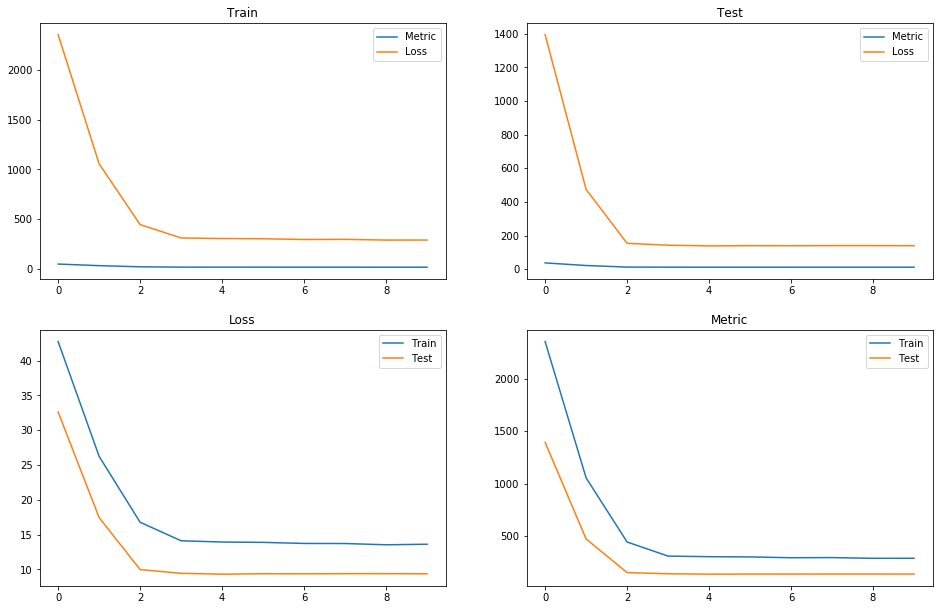

In [34]:
    fig = plt.figure()
    fig.set_size_inches(16,16)

    ax=fig.add_subplot(3,2,1)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Train')

    ax=fig.add_subplot(3,2,2)
    ax.plot(hist.history['val_rmse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Test')

    ax=fig.add_subplot(3,2,3)
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Loss')

    ax=fig.add_subplot(3,2,4)
    ax.plot(hist.history['mse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Metric')

In [44]:
X1_test = pd.read_csv('00_Data/fnc.csv')
X1_test = X1_test[X1_test['Id'].isin(TEST_IDS)]
X1_test = X1_test.to_numpy()
X1_test = X1_test[:,1:]

In [45]:
X2_test = pd.read_csv('00_Data/loading.csv')
X2_test = X2_test[X2_test['Id'].isin(TEST_IDS)]
X2_test = X2_test.to_numpy()
X2_test = X2_test[:,1:]

In [46]:
y_preds = model.predict([X1_test, X2_test])

In [47]:
y_preds = y_preds.flatten()

In [48]:
df_submission = []
i = 0
for idx in TEST_IDS:
    df_submission.append(['{0}_age'.format(idx), y_preds[i]])
    df_submission.append(['{0}_domain1_var1'.format(idx), y_preds[i+1]])
    df_submission.append(['{0}_domain1_var2'.format(idx), y_preds[i+2]])
    df_submission.append(['{0}_domain2_var1'.format(idx), y_preds[i+3]])
    df_submission.append(['{0}_domain2_var2'.format(idx), y_preds[i+4]])
    i += 5

df_submission = pd.DataFrame(df_submission, columns=['Id', 'Predicted'])

In [50]:
df_submission.to_csv('submission_fnc-load_mae_01.csv', index=False)